# Forest cover type prediction - MAP553 challenge

### Pierre Aguié

In [1]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn import show_versions

import seaborn as sns

from scipy.stats import uniform, randint

In [2]:
# Had some dependancy issues when running the code, this is just to show what versions worked for me

print(show_versions())


System:
    python: 3.9.7 (default, Sep 16 2021, 08:50:36)  [Clang 10.0.0 ]
executable: /Users/pierreaguie/opt/anaconda3/bin/python
   machine: macOS-10.16-x86_64-i386-64bit

Python dependencies:
      sklearn: 1.1.2
          pip: 23.2.1
   setuptools: 58.0.4
        numpy: 1.26.3
        scipy: 1.11.3
       Cython: 0.29.24
       pandas: 1.3.4
   matplotlib: 3.4.3
       joblib: 1.3.2
threadpoolctl: 3.1.0

Built with OpenMP: True

threadpoolctl info:
       user_api: blas
   internal_api: openblas
         prefix: libopenblas
       filepath: /Users/pierreaguie/opt/anaconda3/lib/python3.9/site-packages/numpy/.dylibs/libopenblas64_.0.dylib
        version: 0.3.23.dev
threading_layer: pthreads
   architecture: Nehalem
    num_threads: 8

       user_api: blas
   internal_api: mkl
         prefix: libmkl_rt
       filepath: /Users/pierreaguie/opt/anaconda3/lib/libmkl_rt.1.dylib
        version: 2021.4-Product
threading_layer: intel
    num_threads: 8

       user_api: openmp
   intern

## Data preprocessing

In [2]:
# Get training data

train_path = "/Users/pierreaguie/KAGGLE_MAP553/train.csv"

train_data = np.array(pd.read_csv(train_path))
X_train = train_data[:,1:55]
y_train = train_data[:,-1] - 1             

In [3]:
# Get prediction data

pred_path = "/Users/pierreaguie/KAGGLE_MAP553/test-full.csv"

pred_data = np.array(pd.read_csv(pred_path))
X_pred = pred_data[:,1:]

In [4]:
def ELU(soil_matrix: np.ndarray):
    """
    Input: One-hot encoded matrix of soil types (size: n, 40)
    Output: One-hot encoded matrix of geologic and climatic zones (size: n, 16)
    """
    n, _ = soil_matrix.shape
    soil_type = soil_matrix.argmax(axis = 1)
    ELU = np.array(
        [2702, 2703, 2704, 2705, 2706, 2717, 3501, 3502, 4201, 4703, 4704, 4744, 4758, 5101, 5151, 6101, 6102, 6731, 7101, 7102, 7103, 7201, 7202, 7700, 7701, 7702, 7709, 7710, 7745, 7746, 7755, 7756, 7757, 7790, 8703, 8707, 8708, 8771, 8772, 8776]
        )
    OHE = np.zeros((n,16))
    for i in range(n):
        soil = str(ELU[soil_type[i]])
        climatic_zone = int(soil[0])
        geologic_zone = int(soil[1])
        OHE[i,climatic_zone - 1] = 1
        OHE[i,7 + geologic_zone] = 1
    return OHE

In [5]:
# Adding one-hot encoded columns for climate and geologic zones (16 more columns)

X_train = np.concatenate((X_train, ELU(X_train[:,14:])), axis = 1)
X_pred = np.concatenate((X_pred, ELU(X_pred[:,14:])), axis = 1)

In [6]:
# Changing dtype to float

X_train = X_train * 1.
X_pred = X_pred * 1.

In [7]:
# Scaling of training and testing data

scaler = StandardScaler()

Z_train = X_train[:,0:10]
Z_pred = X_pred[:,0:10]

Z_train = scaler.fit_transform(Z_train)
Z_pred = scaler.transform(Z_pred)

X_train[:,0:10] = Z_train.copy()
X_pred[:,0:10] = Z_pred.copy()

## EDA

In [2]:
# Get data

train_path = "/Users/pierreaguie/KAGGLE_MAP553/train.csv"
train_df = pd.read_csv(train_path)

test_path = "/Users/pierreaguie/KAGGLE_MAP553/test-full.csv"
test_df = pd.read_csv(test_path)

In [32]:
# Check that the data is clean and has no NA value
train_df.notna().all().all(), test_df.notna().all().all()

(True, True)

In [3]:
# Summary of numerical features in the training dataset
train_df.iloc[:,1:11].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Elevation,15120.0,2748.649934,419.009589,1877.0,2373.0,2754.0,3109.0,3850.0
Aspect,15120.0,155.834524,109.745372,0.0,65.0,125.0,257.0,360.0
Slope,15120.0,16.556746,8.534602,0.0,10.0,15.0,22.0,50.0
Horizontal_Distance_To_Hydrology,15120.0,228.376521,209.196381,0.0,67.0,180.0,330.0,1376.0
Vertical_Distance_To_Hydrology,15120.0,51.311706,61.520488,-135.0,5.0,32.0,80.0,570.0
Horizontal_Distance_To_Roadways,15120.0,1717.977712,1330.263450,0.0,760.0,1315.0,2292.0,6803.0
Hillshade_9am,15120.0,213.028836,30.638406,52.0,197.0,220.0,236.0,254.0
Hillshade_Noon,15120.0,218.865741,22.797288,99.0,207.0,223.0,235.0,254.0
Hillshade_3pm,15120.0,134.477116,46.070054,0.0,106.0,138.0,166.0,251.0
Horizontal_Distance_To_Fire_Points,15120.0,1527.357804,1116.636997,0.0,750.0,1266.0,2002.0,7095.0


In [4]:
# Summary of numerical features in the testing dataset
test_df.iloc[:,1:11].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Elevation,581012.0,2959.365301,279.984734,1859.0,2809.0,2996.0,3163.0,3858.0
Aspect,581012.0,155.656807,111.913721,0.0,58.0,127.0,260.0,360.0
Slope,581012.0,14.103704,7.488242,0.0,9.0,13.0,18.0,66.0
Horizontal_Distance_To_Hydrology,581012.0,269.428217,212.549356,0.0,108.0,218.0,384.0,1397.0
Vertical_Distance_To_Hydrology,581012.0,46.418855,58.295232,-173.0,7.0,30.0,69.0,601.0
Horizontal_Distance_To_Roadways,581012.0,2350.146611,1559.254870,0.0,1106.0,1997.0,3328.0,7117.0
Hillshade_9am,581012.0,212.146049,26.769889,0.0,198.0,218.0,231.0,254.0
Hillshade_Noon,581012.0,223.318716,19.768697,0.0,213.0,226.0,237.0,254.0
Hillshade_3pm,581012.0,142.528263,38.274529,0.0,119.0,143.0,168.0,254.0
Horizontal_Distance_To_Fire_Points,581012.0,1980.291226,1324.195210,0.0,1024.0,1710.0,2550.0,7173.0


In [5]:
# Number of datapoints for each class in the training dataset
train_df["Cover_Type"].value_counts()

1    2160
2    2160
3    2160
4    2160
5    2160
6    2160
7    2160
Name: Cover_Type, dtype: int64

In [9]:
# Proportion of each wilderness area
train_df.iloc[:,11:15].sum()/15120

Wilderness_Area1    0.235979
Wilderness_Area2    0.037632
Wilderness_Area3    0.416799
Wilderness_Area4    0.309590
dtype: float64

In [33]:
# Mean for each class
train_df.groupby("Cover_Type").mean().iloc[:,1:11].T

Cover_Type,1,2,3,4,5,6,7
Elevation,3129.958333,2922.785185,2393.389815,2224.697222,2789.718056,2417.350000,3362.650926
Aspect,155.886574,151.112500,173.583796,138.897685,138.058796,179.995833,153.306481
Slope,13.197685,13.381019,20.700000,18.640741,16.680556,19.177778,14.119444
Horizontal_Distance_To_Hydrology,278.717593,280.282407,205.216204,109.110648,215.434259,155.617130,354.257407
Vertical_Distance_To_Hydrology,43.755556,47.406481,61.789815,41.622685,50.299537,44.535648,69.772222
Horizontal_Distance_To_Roadways,2625.805556,2449.349074,953.921296,923.306481,1341.518981,1034.187500,2697.755093
Hillshade_9am,212.421759,214.313426,202.473611,228.250000,223.545833,192.450000,217.747222
Hillshade_Noon,223.207870,225.137963,215.565278,217.081944,218.815741,209.788889,222.462500
Hillshade_3pm,143.096759,142.375463,139.583796,111.425000,121.501389,148.501852,134.855556
Horizontal_Distance_To_Fire_Points,2026.214352,2206.857407,906.714352,864.336111,1577.146759,1062.846759,2047.388889


In [34]:
# Std dev for each class
train_df.groupby("Cover_Type").std().iloc[:,1:11].T

Cover_Type,1,2,3,4,5,6,7
Elevation,157.237588,184.150059,193.763783,101.561400,94.322325,190.912952,110.637319
Aspect,117.240246,108.654275,107.817029,87.484210,90.768030,132.967779,109.829269
Slope,6.808387,7.101312,8.961593,9.412211,8.402496,8.164126,7.170173
Horizontal_Distance_To_Hydrology,222.040614,206.335966,143.205864,141.012094,179.982585,121.793804,292.662595
Vertical_Distance_To_Hydrology,58.823737,60.125857,58.477070,59.135283,58.387087,46.363933,79.305064
Horizontal_Distance_To_Roadways,1517.486824,1604.188545,622.865249,362.979644,1043.335814,569.887310,1198.910720
Hillshade_9am,24.950853,24.362467,40.575689,24.346569,22.977519,34.091712,22.940626
Hillshade_Noon,17.877014,17.962403,27.658950,20.844852,25.311736,25.017138,19.065171
Hillshade_3pm,36.104583,35.723713,51.823608,49.691283,50.180056,45.691466,38.246676
Horizontal_Distance_To_Fire_Points,1270.258494,1461.231902,515.647211,479.964514,979.360489,585.004481,1077.139281


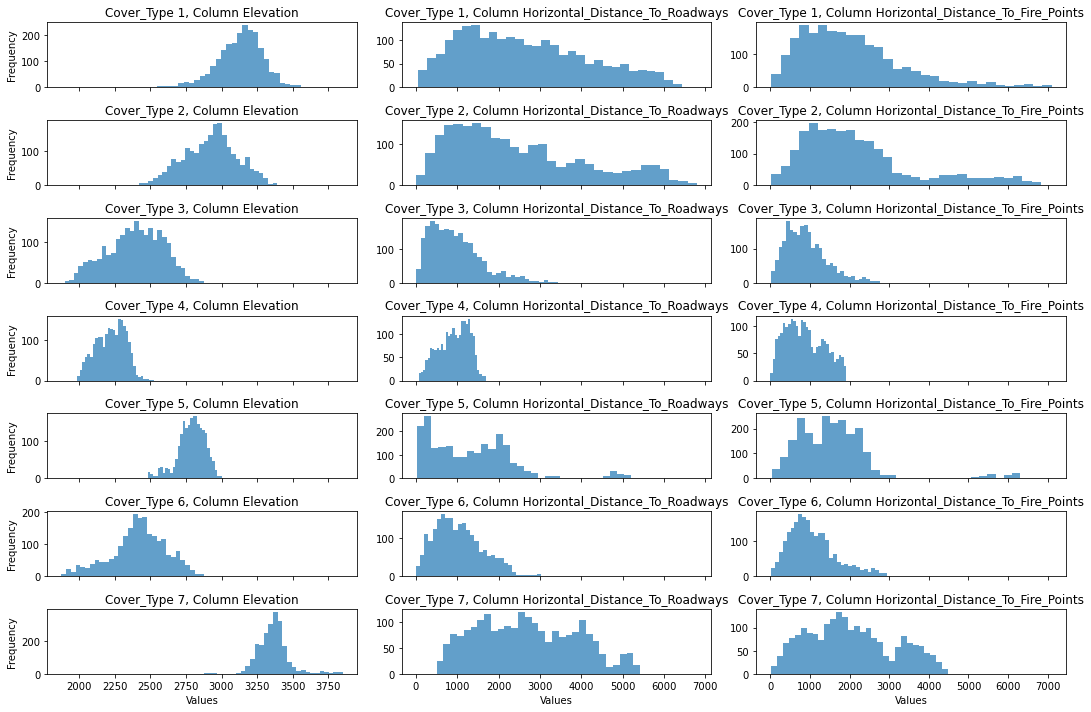

In [85]:
feat = ["Elevation", "Horizontal_Distance_To_Roadways", "Horizontal_Distance_To_Fire_Points"]


columns_of_interest = [1, 6, 10]

cover_types = train_df['Cover_Type'].unique()

fig, axes = plt.subplots(nrows=len(cover_types), ncols=len(columns_of_interest), figsize=(15, 10), sharex='col')

for i, cover_type in enumerate(cover_types):
    subset = train_df[train_df['Cover_Type'] == cover_type].iloc[:, columns_of_interest]
    
    for j, col in enumerate(columns_of_interest):
        axes[i, j].hist(subset.iloc[:, j], bins=30, alpha=0.7)
        axes[i, j].set_title(f'Cover_Type {cover_type}, Column {feat[j]}')

for ax in axes[-1, :]:
    ax.set_xlabel('Values')
for ax in axes[:, 0]:
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()


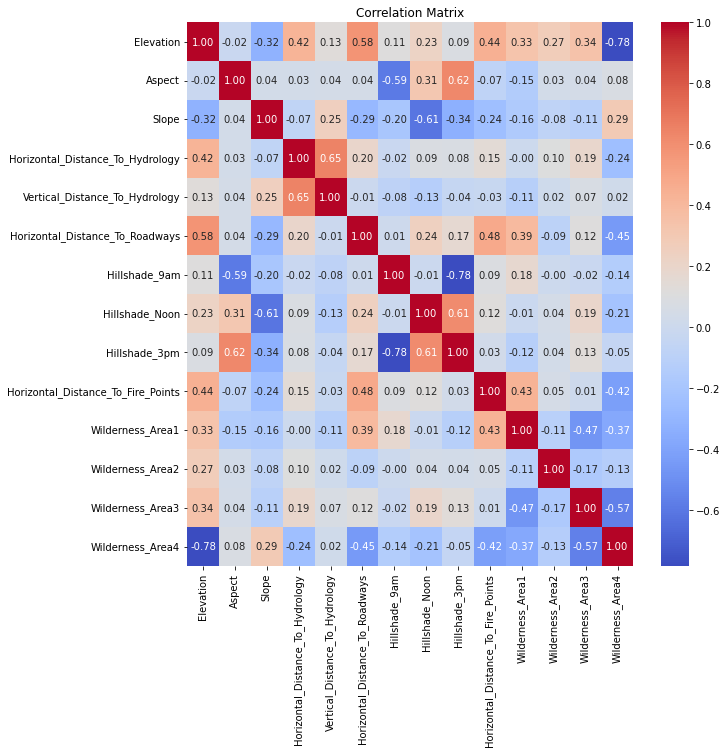

In [93]:
# Correlation matrix

correlation_matrix = train_df.iloc[:,1:15].corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [8]:
# Perform PCA on the numerical features of the training set for visualization

X_visu = X_train[:,:10]

n_components = 10 
pca = PCA(n_components=n_components)

pca.fit(X_visu)

X_pca = pca.transform(X_visu)

array([2.84224374e-01, 2.31493580e-01, 1.80268690e-01, 1.06508618e-01,
       5.50331327e-02, 4.81794619e-02, 4.02976861e-02, 2.88496875e-02,
       2.48863696e-02, 2.58400630e-04])

In [ ]:
# Print the exlpained variances

explained_variance = pca.explained_variance_ratio_
explained_variance

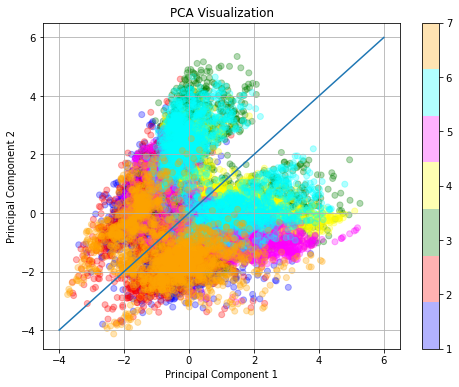

In [34]:
# Print a scatter plot to visualize the data

from matplotlib.colors import ListedColormap

X2_pca = pca.transform(X_pred[:,:10])

i1, i2 = 0, 1

plt.figure(figsize=(8, 6))

colors = ['blue','red','green','yellow','magenta','cyan','orange']
cm = ListedColormap(colors, N = 7)

scatter = plt.scatter(.85*X_pca[:, i1] + .3, X_pca[:, i2], c = y_train + 1, cmap = cm, alpha=0.3, label = 'a')

# Uncomment to show the testing set as well
# plt.scatter(X2_pca[:, i1], X2_pca[:, i2], alpha=0.2, color = 'black')

plt.colorbar(scatter)
plt.title('PCA Visualization')
plt.xlabel(f'Principal Component {i1+1}')
plt.ylabel(f'Principal Component {i2+1}')
plt.grid()
plt.show()

## Data acquisition and processing

In [ ]:
# Get training data

train_path = "/Users/pierreaguie/KAGGLE_MAP553/train.csv"

train_data = np.array(pd.read_csv(train_path))
X_train = train_data[:,1:55]
y_train = train_data[:,-1] - 1             

In [ ]:
# Get prediction data

pred_path = "/Users/pierreaguie/KAGGLE_MAP553/test-full.csv"

pred_data = np.array(pd.read_csv(pred_path))
X_pred = pred_data[:,1:]

In [ ]:
def ELU(soil_matrix: np.ndarray):
    """
    Input: One-hot encoded matrix of soil types (size: n, 40)
    Output: One-hot encoded matrix of geologic and climatic zones (size: n, 16)
    """
    n, _ = soil_matrix.shape
    soil_type = soil_matrix.argmax(axis = 1)
    ELU = np.array(
        [2702, 2703, 2704, 2705, 2706, 2717, 3501, 3502, 4201, 4703, 4704, 4744, 4758, 5101, 5151, 6101, 6102, 6731, 7101, 7102, 7103, 7201, 7202, 7700, 7701, 7702, 7709, 7710, 7745, 7746, 7755, 7756, 7757, 7790, 8703, 8707, 8708, 8771, 8772, 8776]
        )
    OHE = np.zeros((n,16))
    for i in range(n):
        soil = str(ELU[soil_type[i]])
        climatic_zone = int(soil[0])
        geologic_zone = int(soil[1])
        OHE[i,climatic_zone - 1] = 1
        OHE[i,7 + geologic_zone] = 1
    return OHE

In [ ]:
# Adding one-hot encoded columns for climate and geologic zones (16 more columns)

X_train = np.concatenate((X_train, ELU(X_train[:,14:])), axis = 1)
X_pred = np.concatenate((X_pred, ELU(X_pred[:,14:])), axis = 1)

In [ ]:
# Changing dtype to float

X_train = X_train * 1.
X_pred = X_pred * 1.

In [ ]:
# Scaling of training and testing data

scaler = StandardScaler()

Z_train = X_train[:,0:10]
Z_pred = X_pred[:,0:10]

Z_train = scaler.fit_transform(Z_train)
Z_pred = scaler.transform(Z_pred)

X_train[:,0:10] = Z_train.copy()
X_pred[:,0:10] = Z_pred.copy()

## Random Forest Classifier

In [11]:
# Train multiple RFClassifiers by tuning hyperparameters using GridSearchCV

from sklearn.ensemble import RandomForestClassifier

modelRF = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=modelRF, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_model_RF = grid_search.best_estimator_

In [12]:
# Accuracy of the best model on the training set
grid_search.best_score_

0.8522486772486773

In [13]:
# Best hyperparameters
grid_search.best_params_

{'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

In [7]:
# Train a RFClassifier with the best hyperparameters using the whole dataset

from sklearn.ensemble import RandomForestClassifier

modelRF2 = RandomForestClassifier(n_estimators=300, min_samples_leaf=1, min_samples_split=2, max_depth=None)
modelRF2.fit(X_train,y_train)

RandomForestClassifier(n_estimators=300)

In [9]:
# Calculate accuracy

test_preds_RF = modelRF2.predict(X_train)

accuracy = accuracy_score(y_train, test_preds_RF)
print(f"Accuracy: {accuracy}")

Accuracy: 1.0


In [10]:
# Make predictions

y_RF = modelRF2.predict(X_pred) + 1
y_RF

array([5, 5, 2, ..., 3, 6, 6])

In [12]:
# Save predictions into a .csv

PredictionsRF = pd.DataFrame(y_RF, columns = ["Cover_Type"], index = np.arange(1, len(y_RF) + 1))
PredictionsRF.index.name = "Id"
PredictionsRF.to_csv("/Users/pierreaguie/KAGGLE_MAP553/predsRF.csv")

## SVM

In [8]:
# Train multiple SVCs by tuning hyperparameters using GridSearchCV

from sklearn.svm import SVC

modelSVM = SVC(kernel="rbf", gamma="scale")
param_grid = {
    'C': [.1, 1, 10, 100, 200, 500],
}

grid_search = GridSearchCV(estimator = modelSVM, param_grid = param_grid, cv = 5)
grid_search.fit(X_train,  y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best parameters : {best_params}")
print(f"Score : {best_model.score(X_train, y_train)}")

Best parameters : {'C': 200}
Score : 0.9455026455026455


In [9]:
# Make predictions using the best model

y_SVM = best_model.predict(X_pred) + 1
y_SVM

In [400]:
# Put predictions into .csv

PredictionsSVM = pd.DataFrame(y_SVM, columns = ["Cover_Type"], index = np.arange(1, len(y_pred) + 1))
PredictionsSVM.index.name = "Id"
PredictionsSVM.to_csv("/Users/pierreaguie/KAGGLE_MAP553/predsSVM.csv")

## XGBoost

In [31]:
# Grid Search
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dpred = xgb.DMatrix(X_pred)

params = {
    'objective': ['multi:softmax'],
    'num_class': [7],
    'max_depth': [3, 6, 9, 12],
    'eta': [0.1, 0.2, 0.3, .5, 1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2, .3, .4],
}

xgb_classifier = xgb.XGBClassifier()

grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Best parameters: {'colsample_bytree': 1.0, 'eta': 0.2, 'gamma': 0, 'max_depth': 12, 'num_class': 7, 'objective': 'multi:softmax', 'subsample': 1.0}
Best score:  0.8349043556691343


In [12]:
# Random Search
import xgboost as xgb

param_grid = {
    'learning_rate': uniform(0.15, 0.2),  
    'max_depth': randint(7, 11), 
    'n_estimators': randint(100, 500),  
    'gamma': uniform(0, .2), 
    'min_child_weight': randint(5, 10),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.8, 0.2),
    'reg_lambda': uniform(2, 2)  # L2 regularization
}

xgb_classifier = xgb.XGBClassifier(objective='multi:softmax', num_class=7)

random_search = RandomizedSearchCV(
    estimator=xgb_classifier,
    param_distributions=param_grid,
    n_iter=50, 
    scoring='accuracy', 
    cv=5,  
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print("Best Parameters:", best_params)

best_score = random_search.best_score_
print(f"Best Score: {best_score}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'colsample_bytree': 0.9358446038337874, 'gamma': 0.008350397968643652, 'learning_rate': 0.3290625549899804, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 235, 'reg_lambda': 3.805998314361929, 'subsample': 0.9001252221914515}
Best Score: 0.8621693121693121


In [13]:
modelXGB = random_search.best_estimator_

y_XGB = modelXGB.predict(X_pred) + 1
y_XGB

array([5, 5, 2, ..., 3, 3, 3], dtype=int32)

In [17]:
PredictionsXGB = pd.DataFrame(y_XGB, columns = ["Cover_Type"], index = np.arange(1, len(y_XGB) + 1))
PredictionsXGB.index.name = "Id"
PredictionsXGB.to_csv("/Users/pierreaguie/KAGGLE_MAP553/predsXGB.csv")

## Neural Network

In [26]:
from sklearn.neural_network import MLPClassifier

modelMLP = MLPClassifier(activation="relu", hidden_layer_sizes=(100,100,50))

param_grid = {
    'alpha': [0.0001, 0.001, 0.1],
    'solver': ['adam'],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [100, 200],
    'batch_size': [32, 64],
}

grid_search_MLP = GridSearchCV(modelMLP, param_grid, cv = 5, scoring = 'accuracy', verbose = 1)
grid_search_MLP.fit(X_train, y_train)

best_params_MLP = grid_search_MLP.best_params_
best_model_MLP = grid_search_MLP.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/Users/pierreaguie/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/pierreaguie/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/pierreaguie/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/pierreaguie/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


0.904431216931217

In [27]:
accuracy

0.904431216931217

In [28]:
best_params_MLP

{'activation': 'relu',
 'alpha': 0.001,
 'batch_size': 32,
 'hidden_layer_sizes': (50, 50),
 'learning_rate': 'constant',
 'max_iter': 200,
 'solver': 'adam'}

In [41]:
modelMLP = MLPClassifier(hidden_layer_sizes=(100,100,50), activation='relu', batch_size= 64, alpha=.0005, learning_rate='adaptive', max_iter=200, solver='adam', verbose = True, early_stopping=True)
modelMLP.fit(X_train, y_train)

Iteration 1, loss = 0.95951326
Validation score: 0.693122
Iteration 2, loss = 0.69203650
Validation score: 0.722884
Iteration 3, loss = 0.64171034
Validation score: 0.741402
Iteration 4, loss = 0.60688757
Validation score: 0.732143
Iteration 5, loss = 0.58895634
Validation score: 0.749339
Iteration 6, loss = 0.57054831
Validation score: 0.743386
Iteration 7, loss = 0.55408523
Validation score: 0.771164
Iteration 8, loss = 0.53959364
Validation score: 0.763228
Iteration 9, loss = 0.52767758
Validation score: 0.778439
Iteration 10, loss = 0.51034235
Validation score: 0.775794
Iteration 11, loss = 0.49714496
Validation score: 0.782407
Iteration 12, loss = 0.48642245
Validation score: 0.785053
Iteration 13, loss = 0.47093267
Validation score: 0.790344
Iteration 14, loss = 0.45880573
Validation score: 0.788360
Iteration 15, loss = 0.45234242
Validation score: 0.790344
Iteration 16, loss = 0.44505464
Validation score: 0.798942
Iteration 17, loss = 0.43770620
Validation score: 0.802910
Iterat

MLPClassifier(alpha=0.0005, batch_size=64, early_stopping=True,
              hidden_layer_sizes=(100, 100, 50), learning_rate='adaptive',
              verbose=True)

In [42]:
modelMLP.score(X_test, y_test)

NameError: name 'X_test' is not defined

In [64]:
y_MLP = modelMLP.predict(X_pred) + 1
y_MLP

array([5, 5, 2, ..., 3, 6, 6])

In [65]:
PredictionsMLP = pd.DataFrame(y_MLP, columns = ["Cover_Type"], index = np.arange(1, len(y_MLP) + 1))
PredictionsMLP.index.name = "Id"
PredictionsMLP.to_csv("/Users/pierreaguie/KAGGLE_MAP553/predsMLP2.csv")

## K-NN clustering

In [18]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors': [2, 3, 4, 5, 7, 9, 11]}

knn = KNeighborsClassifier() 
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')


grid_search.fit(X_train, y_train)

best_k = grid_search.best_params_['n_neighbors']
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [10]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [11]:
y_predtrain = knn.predict(X_train)
accuracy = accuracy_score(y_predtrain, y_train)
accuracy

0.8641534391534391

In [31]:
y_KNN = knn.predict(X_pred)

In [32]:
PredictionsKNN = pd.DataFrame(y_KNN + 1, columns = ["Cover_Type"], index = np.arange(1, len(y_KNN) + 1))
PredictionsKNN.index.name = "Id"
PredictionsKNN.to_csv("/Users/pierreaguie/KAGGLE_MAP553/predsKNN.csv")

## ExtraTree

In [10]:
from sklearn.ensemble import ExtraTreesClassifier

# Create ExtraTreesClassifier
extra_trees = ExtraTreesClassifier()

# Define hyperparameters to search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=extra_trees, param_grid=param_grid, cv=5, scoring='accuracy', verbose = 1)
grid_search.fit(X_train, y_train)

# Get best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Score: 0.8592592592592592


In [11]:
y_extra = grid_search.best_estimator_.predict(X_pred)

In [12]:
PredictionsExtra = pd.DataFrame(y_extra + 1, columns = ["Cover_Type"], index = np.arange(1, len(y_extra) + 1))
PredictionsExtra.index.name = "Id"
PredictionsExtra.to_csv("/Users/pierreaguie/KAGGLE_MAP553/predsExtra.csv")

In [13]:
y_extra

array([4, 4, 1, ..., 2, 5, 5])

## Model stacking

In [11]:
from sklearn.ensemble import StackingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

import xgboost as xgb

from sklearn.model_selection import KFold

In [35]:
base_models = [
    ('rf',RandomForestClassifier(max_depth=20,min_samples_leaf=1,min_samples_split=2,n_estimators=300)),
    ('xgb', xgb.XGBClassifier(objective='multi:softmax', num_class=7, max_depth = 9, n_estimators = 385, gamma = 0.01127, learning_rate = .2, reg_lambda = 2.3)),
    ('mlp', MLPClassifier(hidden_layer_sizes=(100,100,50), activation='relu', batch_size= 64, alpha=.0015, learning_rate='adaptive', max_iter=500, solver='adam')),
    ('knn', KNeighborsClassifier(n_neighbors=6)),
    ('et', ExtraTreesClassifier(n_estimators = 300))
    #('svm', SVC(C = 50., kernel = "rbf", gamma = "scale"))
]

meta_model = LogisticRegression(max_iter=300)

stack_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

stack_model.fit(X_train, y_train)

print(f"Accuracy : {stack_model.score(X_train, y_train)}")

Accuracy : 1.0


In [36]:
y_stack = stack_model.predict(X_pred)

In [37]:
PredictionsStack = pd.DataFrame(y_stack + 1, columns = ["Cover_Type"], index = np.arange(1, len(y_stack) + 1))
PredictionsStack.index.name = "Id"
PredictionsStack.to_csv("/Users/pierreaguie/KAGGLE_MAP553/predsStack.csv")

In [38]:
y_stack

array([4, 4, 1, ..., 2, 2, 2])

## AutoML

In [9]:
# Use TPOT to find autamatically the best pipeline

from tpot import TPOTClassifier

pipeline_optimizer = TPOTClassifier(generations=20, population_size=20, cv=5,
                                    random_state=42, verbosity=2)

pipeline_optimizer.fit(X_train, y_train)

                                                                                   
Generation 1 - Current best internal CV score: 0.8338624338624339
                                                                                   
Generation 2 - Current best internal CV score: 0.8338624338624339
                                                                                   
Generation 3 - Current best internal CV score: 0.8534391534391534
                                                                                   
Generation 4 - Current best internal CV score: 0.8535714285714286
                                                                                  
Generation 5 - Current best internal CV score: 0.8563492063492063
                                                                                  
Generation 6 - Current best internal CV score: 0.8563492063492063
                                                                                    
Generation 7 - Cu

TPOTClassifier(generations=20, population_size=20, random_state=42, verbosity=2)

In [10]:
pipeline_optimizer.fitted_pipeline_

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=False, max_features=0.4,
                                        min_samples_split=3,
                                        random_state=42))])

In [11]:
pipeline_optimizer.score(X_train, y_train)

1.0

In [12]:
y_TPOT = pipeline_optimizer.predict(X_pred)

In [13]:
PredictionsTPOT = pd.DataFrame(y_TPOT + 1, columns = ["Cover_Type"], index = np.arange(1, len(y_TPOT) + 1))
PredictionsTPOT.index.name = "Id"
PredictionsTPOT.to_csv("/Users/pierreaguie/KAGGLE_MAP553/predsTPOT.csv")

## Model stacking, trained on each wilderness area

In [8]:
from sklearn.ensemble import StackingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

import xgboost as xgb

from sklearn.model_selection import KFold

In [9]:
# Separate the training dataset into 4 according to the wilderness area, and removing the wilderness areas columns

wilderness_area_mask_1 = X_train[:,10] == 1
wilderness_area_mask_2 = X_train[:,11] == 1
wilderness_area_mask_3 = X_train[:,12] == 1
wilderness_area_mask_4 = X_train[:,13] == 1

wilderness_areas_columns = np.array([True] * X_train.shape[1])
wilderness_areas_columns[10:14] = False

X_train = X_train[:,wilderness_areas_columns]

X_train_1 = X_train[wilderness_area_mask_1,:]
X_train_2 = X_train[wilderness_area_mask_2,:]
X_train_3 = X_train[wilderness_area_mask_3,:]
X_train_4 = X_train[wilderness_area_mask_4,:]

y_train_1 = y_train[wilderness_area_mask_1]
y_train_2 = y_train[wilderness_area_mask_2]
y_train_3 = y_train[wilderness_area_mask_3]
y_train_4 = y_train[wilderness_area_mask_4]

In [10]:
# Delete columns with only zeroes in the training set

zero_columns_mask_1 = ~np.all(X_train_1 == 0, axis=0)
X_train_1 = X_train_1[:, zero_columns_mask_1]

zero_columns_mask_2 = ~np.all(X_train_2 == 0, axis=0)
X_train_2 = X_train_2[:, zero_columns_mask_2]

zero_columns_mask_3 = ~np.all(X_train_3 == 0, axis=0)
X_train_3 = X_train_3[:, zero_columns_mask_3]

zero_columns_mask_4 = ~np.all(X_train_4 == 0, axis=0)
X_train_4 = X_train_4[:, zero_columns_mask_4]

In [11]:
train_sets = [(X_train_1, y_train_1), (X_train_2, y_train_2), (X_train_3, y_train_3), (X_train_4, y_train_4)]

In [12]:
# Training 4 different models for each wilderness area

models = []

for X, y in train_sets:
    base_models = [
        ('rf',RandomForestClassifier(max_depth=20,min_samples_leaf=1,min_samples_split=2,n_estimators=300)),
        ('xgb', xgb.XGBClassifier(objective='multi:softmax', num_class=7, max_depth = 9, n_estimators = 385, gamma = 0.01127, learning_rate = .2, reg_lambda = 5.)),
        ('mlp', MLPClassifier(hidden_layer_sizes=(100,100,50), activation='relu', batch_size= 64, alpha=.007, learning_rate='adaptive', max_iter=500, solver='adam')),
        ('knn', KNeighborsClassifier(n_neighbors=6)),
        ('et', ExtraTreesClassifier(n_estimators = 300))
        #('svm', SVC(C = 50., kernel = "rbf", gamma = "scale"))
    ]

    meta_model = LogisticRegression(max_iter=300)

    model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

    model.fit(X, y)

    models.append(model)

    print(f"Accuracy: {model.score(X, y)}")

Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0


In [13]:
# Create the predictio, vectors for each wilderness area
# Grouping datapoints by wilderness area in matrices instead of predicting for each individual datapoint allows for more efficient computations 

idx1 = np.where(X_pred[:,10] == 1)[0]
idx2 = np.where(X_pred[:,11] == 1)[0]
idx3 = np.where(X_pred[:,12] == 1)[0]
idx4 = np.where(X_pred[:,13] == 1)[0]

X_pred = X_pred[:, wilderness_areas_columns]

X_pred1 = X_pred[idx1, :]
X_pred2 = X_pred[idx2, :]
X_pred3 = X_pred[idx3, :]
X_pred4 = X_pred[idx4, :]

X_pred1 = X_pred1[:, zero_columns_mask_1]
X_pred2 = X_pred2[:, zero_columns_mask_2]
X_pred3 = X_pred3[:, zero_columns_mask_3]
X_pred4 = X_pred4[:, zero_columns_mask_4]


y_pred1 = models[0].predict(X_pred1)
print(y_pred1)

y_pred2 = models[1].predict(X_pred2)
print(y_pred2)

y_pred3 = models[2].predict(X_pred3)
print(y_pred3)

y_pred4 = models[3].predict(X_pred4)
print(y_pred4)

[4 4 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[4 4 4 ... 2 2 2]
[2 2 2 ... 2 2 2]


In [14]:
y_sep = np.zeros(X_pred.shape[0], dtype = int)

for i, idx in enumerate(idx1):
    y_sep[idx] = y_pred1[i]

for i, idx in enumerate(idx2):
    y_sep[idx] = y_pred2[i]

for i, idx in enumerate(idx3):
    y_sep[idx] = y_pred3[i]

for i, idx in enumerate(idx4):
    y_sep[idx] = y_pred4[i]

In [15]:
y_sep

array([4, 4, 1, ..., 2, 2, 2])

In [16]:
PredictionsSep = pd.DataFrame(y_sep + 1, columns = ["Cover_Type"], index = np.arange(1, len(y_sep) + 1))
PredictionsSep.index.name = "Id"
PredictionsSep.to_csv("/Users/pierreaguie/KAGGLE_MAP553/predsSep.csv")